# Prepare Dataset
> Note: Colab only

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Capstone/Eye-Infection-Dataset/ .
!mv ./Eye-Infection-Dataset ./dataset
!rm ./dataset/LICENSE.md
!mkdir export

# Setup

In [28]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from io import BytesIO
from ipywidgets import widgets
from google.colab import files

In [29]:
DATASET_PATH = './dataset'
CLASSES = sorted(os.listdir(DATASET_PATH))
IMAGE_SIZE=(150, 150)

# Data Processing

In [30]:
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    image_size=IMAGE_SIZE,
    label_mode='categorical',
    validation_split=0.2,
    subset='both',
    batch_size=32,
    seed=8
)

Found 615 files belonging to 3 classes.
Using 492 files for training.
Using 123 files for validation.


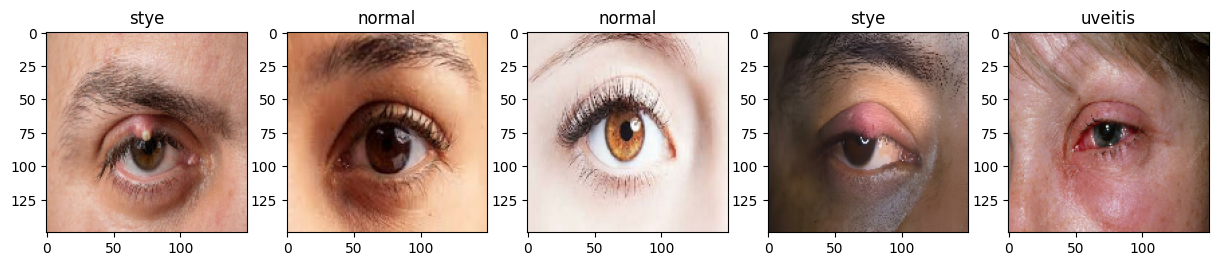

In [31]:
imgs = list(train_ds.take(5))[0]

# print(imgs)

plot, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))

for i, ax in enumerate(axes):
  img = tf.keras.utils.array_to_img(imgs[0][i])
  lbl = CLASSES[np.argmax(imgs[1][i].numpy())]

  ax.title.set_text(lbl)
  ax.imshow(img)

In [32]:
def preprocess_image(image):
  image = tf.cast(image, tf.float32)
  image /= 255.0
  return image

In [33]:
train_ds = train_ds.map(lambda x, y: (preprocess_image(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_image(x), y))

In [34]:
train_ds_pref = train_ds.cache().shuffle(64).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_pref = val_ds.cache().shuffle(64).prefetch(buffer_size=tf.data.AUTOTUNE)

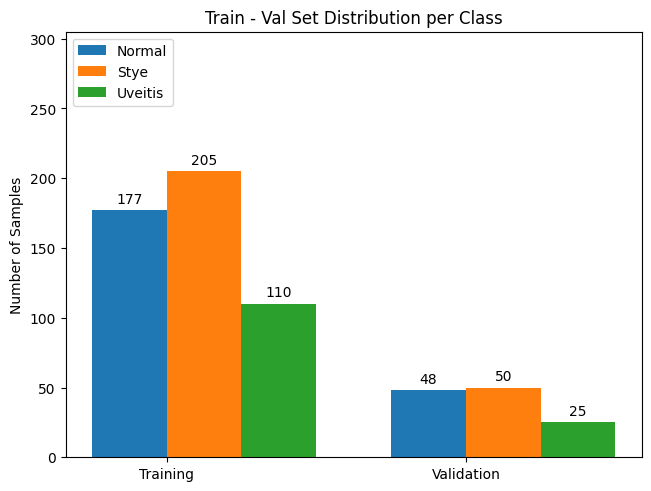

In [35]:
# Hitung jumlah sampel pada dataset train dan validation untuk setiap kelas
train_normal_count = 0
train_stye_count = 0
train_uveitis_count = 0

val_normal_count = 0
val_stye_count = 0
val_uveitis_count = 0

# Loop melalui train_ds untuk menghitung jumlah data per kelas
for images, labels in train_ds:
    train_normal_count += np.sum(labels[:, 0])  # Kelas 'normal' di index 0
    train_stye_count += np.sum(labels[:, 1])    # Kelas 'stye' di index 1
    train_uveitis_count += np.sum(labels[:, 2])  # Kelas 'uveitis' di index 2

# Loop melalui val_ds untuk menghitung jumlah data per kelas
for images, labels in val_ds:
    val_normal_count += np.sum(labels[:, 0])  # Kelas 'normal' di index 0
    val_stye_count += np.sum(labels[:, 1])    # Kelas 'stye' di index 1
    val_uveitis_count += np.sum(labels[:, 2])  # Kelas 'uveitis' di index 2

# Data untuk visualisasi
split = ("Training", "Validation")
num_set = {
    'Normal': (train_normal_count, val_normal_count),
    'Stye': (train_stye_count, val_stye_count),
    'Uveitis': (train_uveitis_count, val_uveitis_count),
}

# Visualisasi data
x = np.arange(len(split))  # posisi label
width = 0.25  # lebar batang
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in num_set.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Menambahkan label, judul, dan menyesuaikan label sumbu-x
ax.set_ylabel('Number of Samples')
ax.set_title('Train - Val Set Distribution per Class')
ax.set_xticks(x + (width / 2), split)
ax.legend(loc='upper left', ncols=1)
ax.set_ylim(0, max(train_normal_count, train_stye_count, train_uveitis_count,
                   val_normal_count, val_stye_count, val_uveitis_count) + 100)

plt.show()

# Model Setup

In [36]:
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    super(CustomCallback, self).__init__()
    self.prev_acc = 0.0

  def on_epoch_end(self, epoch, logs=None):
    self.prev_acc = logs['accuracy']

    # Early stop when there is no accuracy or loss improvement
    if epoch > 30 and self.prev_acc < 0.5:
      self.model.stop_training = True
      print("\nStopped the training because there is no improvement")

    # Early stop when the model has achieved the desired accuracy
    if (logs['loss'] < 0.1 and logs['val_loss'] < 0.1) and (logs['accuracy'] >= 0.95 and logs['val_accuracy'] >= 0.95):
      self.model.stop_training = True
      print("\nAlready met the desired accuracy")

In [51]:
tf.keras.backend.clear_session()

In [52]:
model_aug = tf.keras.models.Sequential([
    tf.keras.Input(shape=IMAGE_SIZE + (3,)),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom((0.0, 0.2), (0.0, 0.2), fill_mode="nearest", seed=16)
])

In [53]:
model = tf.keras.models.Sequential([
    model_aug,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(512, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.1), activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,619,203 (9.99 MB)

 Trainable params: 2,619,203 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= 5.6234e-04),
    loss=tf.keras.losses.Huber(),
    metrics=['accuracy']
)

model_obj = model.fit(
    train_ds,
    epochs=100,
    batch_size=16,
    validation_data=val_ds,
    callbacks=[CustomCallback()]
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.3910 - loss: 71.7685 - val_accuracy: 0.4959 - val_loss: 44.8509
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.4033 - loss: 38.5293 - val_accuracy: 0.4146 - val_loss: 22.5926
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.4412 - loss: 19.1118 - val_accuracy: 0.4390 - val_loss: 10.6004
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.4395 - loss: 8.8452 - val_accuracy: 0.3902 - val_loss: 4.6613
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4594 - loss: 3.8438 - val_accuracy: 0.4228 - val_loss: 1.9430
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4379 - loss: 1.5902 - val_accuracy: 0.4390 - val_loss: 0.7861
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4896 - loss: 0.6464 - val_accuracy: 0.4472 - val_loss: 0.3335
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4705 - loss: 0.2895 - val_accur

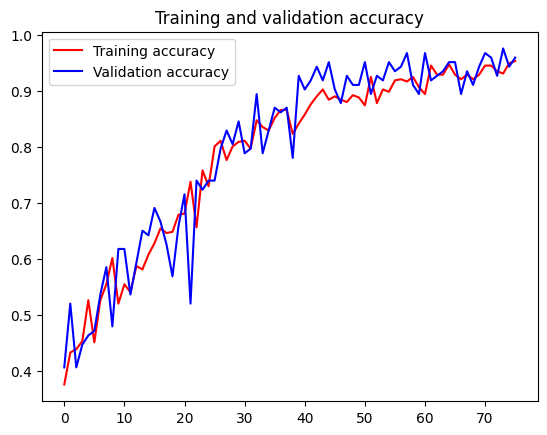

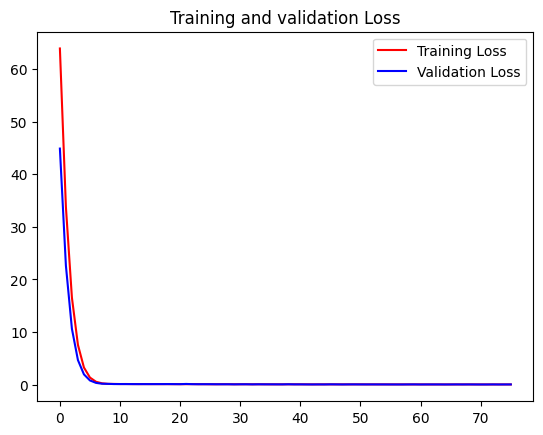

In [41]:
acc = model_obj.history['accuracy']
val_acc = model_obj.history['val_accuracy']
loss = model_obj.history['loss']
val_loss = model_obj.history['val_loss']

epochs = range(len(acc))

# Plot the training and validation accuracies for each epoch
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show()

# Plot the training and validation loss for each epoch
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.show()

# Model Tuning (Experiment)
> This section is only for experiment. Therefore, optional. Make sure you haven't compile or train the model yet!

In [ ]:
# Learning rate scheduler

tf.keras.backend.clear_session()

model_aug = tf.keras.models.Sequential([
    tf.keras.Input(shape=IMAGE_SIZE + (3,)),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom((0.0, 0.2), (0.0, 0.2), fill_mode="nearest", seed=16)
])

model_tn = tf.keras.models.Sequential([
    model_aug,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(512, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.1), activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10 ** (epoch / 40))


In [ ]:
class LearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(LearningRateLogger, self).__init__()
        self.lr_list = []
        self.acc_list = []
        self.val_acc_list = []
        self.loss_list = []
        self.val_loss_list = []

    def on_epoch_end(self, epoch, logs=None):
        # Log learning rate, accuracy, and loss
        lr = self.model.optimizer.learning_rate.numpy()  # Perbaikan di sini
        self.lr_list.append(lr)
        self.acc_list.append(logs['accuracy'])
        self.val_acc_list.append(logs['val_accuracy'])
        self.loss_list.append(logs['loss'])
        self.val_loss_list.append(logs['val_loss'])


In [ ]:
# Initialize the logger
lr_logger = LearningRateLogger()

model_tn.compile(
    loss= tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model_obj_tn = model_tn.fit(
    train_ds,
    epochs=100,
    batch_size=16,
    validation_data=val_ds,
    callbacks=[lr_schedule, lr_logger]
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.3834 - loss: 81.7281 - val_accuracy: 0.4065 - val_loss: 81.1179 - learning_rate: 1.0000e-05
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.4051 - loss: 80.9085 - val_accuracy: 0.4065 - val_loss: 80.2680 - learning_rate: 1.0593e-05
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.3867 - loss: 80.0495 - val_accuracy: 0.4065 - val_loss: 79.3770 - learning_rate: 1.1220e-05
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4088 - loss: 79.1484 - val_accuracy: 0.4065 - val_loss: 78.4439 - learning_rate: 1.1885e-05
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4231 - loss: 78.2037 - val_accuracy: 0.4065 - val_loss: 77.4673 - learning_rate: 1.2589e-05
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4093 - loss: 77.2165 - val_accuracy: 0.4065 - val_loss: 76.4459 - learning_rate: 1.3335e-05
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step 

In [ ]:
def demo_augmentation(sample_image, model, num_aug):
    '''Takes a single image array, then uses a model to generate num_aug transformations'''

    # Instantiate preview list
    image_preview = []

    # Convert input image to a PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(num_aug):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, num_aug + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

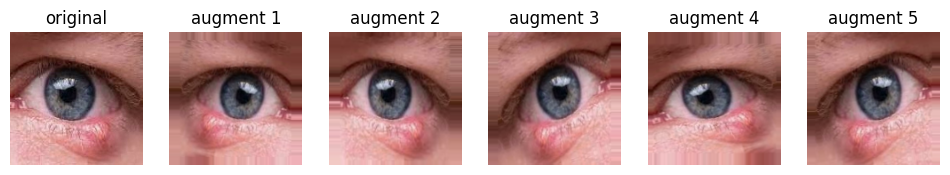

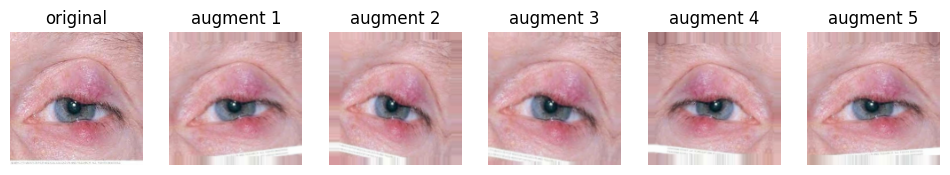

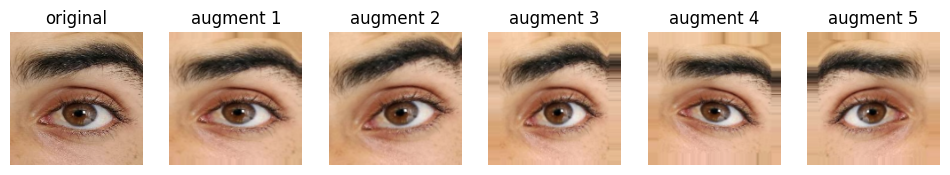

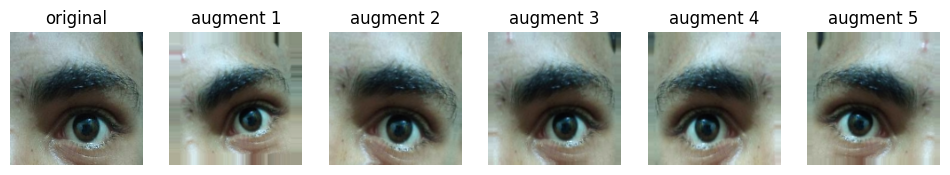

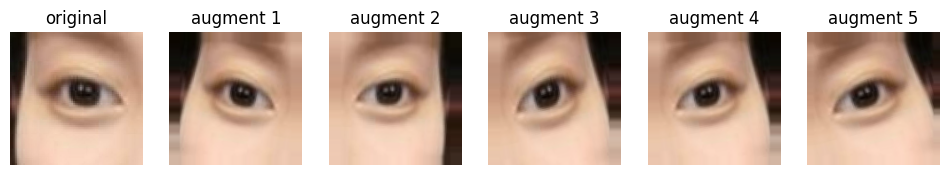

In [ ]:
sample_batch = list(train_ds.take(1))[0][0]

for i in range(5):
  demo_augmentation(sample_batch[i], model_aug, 5)

# Model Evaluation

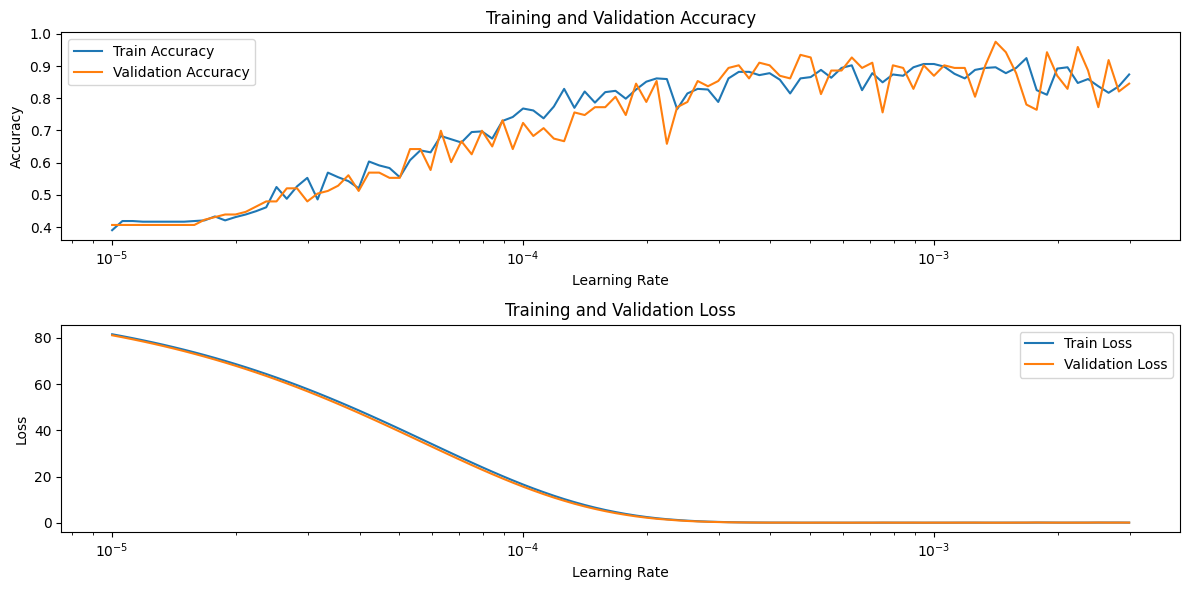

In [ ]:

plt.figure(figsize=(12, 6))

# Plot untuk Akurasi
plt.subplot(2, 1, 1)
plt.plot(lr_logger.lr_list, lr_logger.acc_list, label='Train Accuracy')
plt.plot(lr_logger.lr_list, lr_logger.val_acc_list, label='Validation Accuracy')
plt.xscale('log')  # Skala log untuk learning rate
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot untuk Loss
plt.subplot(2, 1, 2)
plt.plot(lr_logger.lr_list, lr_logger.loss_list, label='Train Loss')
plt.plot(lr_logger.lr_list, lr_logger.val_loss_list, label='Validation Loss')
plt.xscale('log')  # Skala log untuk learning rate
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Menemukan learning rate terbaik berdasarkan metrik
best_train_acc_lr = lr_logger.lr_list[lr_logger.acc_list.index(max(lr_logger.acc_list))]
best_val_acc_lr = lr_logger.lr_list[lr_logger.val_acc_list.index(max(lr_logger.val_acc_list))]
best_train_loss_lr = lr_logger.lr_list[lr_logger.loss_list.index(min(lr_logger.loss_list))]
best_val_loss_lr = lr_logger.lr_list[lr_logger.val_loss_list.index(min(lr_logger.val_loss_list))]

# Menampilkan hasil untuk masing-masing metrik
print(f"Best Train Accuracy Learning Rate: {best_train_acc_lr}")
print(f"Best Validation Accuracy Learning Rate: {best_val_acc_lr}")
print(f"Best Train Loss Learning Rate: {best_train_loss_lr}")
print(f"Best Validation Loss Learning Rate: {best_val_loss_lr}")

print('='*50)

# Menemukan dan mencetak metrik untuk learning rate terbaik
for lr in [best_train_acc_lr, best_val_acc_lr, best_train_loss_lr, best_val_loss_lr]:
    lr_index = lr_logger.lr_list.index(lr)
    print(f"Learning Rate: {lr}")
    print(f" - Best Train Accuracy: {lr_logger.acc_list[lr_index]}")
    print(f" - Best Validation Accuracy: {lr_logger.val_acc_list[lr_index]}")
    print(f" - Best Train Loss: {lr_logger.loss_list[lr_index]}")
    print(f" - Best Validation Loss: {lr_logger.val_loss_list[lr_index]}")
    print()



Best Train Accuracy Learning Rate: 0.0016788040520623326
Best Validation Accuracy Learning Rate: 0.0014125375309959054
Best Train Loss Learning Rate: 0.000630957365501672
Best Validation Loss Learning Rate: 0.0014125375309959054
Learning Rate: 0.0016788040520623326
 - Best Train Accuracy: 0.9247967600822449
 - Best Validation Accuracy: 0.7804877758026123
 - Best Train Loss: 0.048823025077581406
 - Best Validation Loss: 0.08050954341888428

Learning Rate: 0.0014125375309959054
 - Best Train Accuracy: 0.8963414430618286
 - Best Validation Accuracy: 0.9756097793579102
 - Best Train Loss: 0.05706658586859703
 - Best Validation Loss: 0.030491072684526443

Learning Rate: 0.000630957365501672
 - Best Train Accuracy: 0.9024389982223511
 - Best Validation Accuracy: 0.9268292784690857
 - Best Train Loss: 0.04058137908577919
 - Best Validation Loss: 0.03841958940029144

Learning Rate: 0.0014125375309959054
 - Best Train Accuracy: 0.8963414430618286
 - Best Validation Accuracy: 0.9756097793579102


# Testing

Saving download (1).jpg to download (1) (3).jpg
Probability: [0.01023988 0.9847919  0.00496826]
Prediction: stye



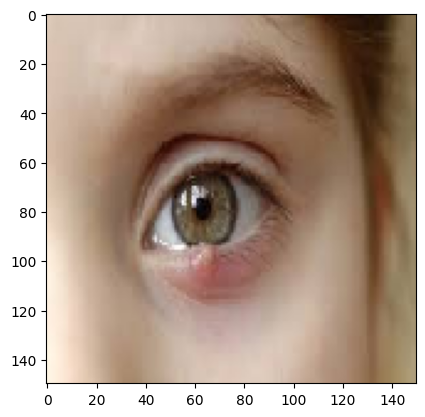

In [50]:
uploaded = files.upload()

for f in uploaded.keys():
  img = tf.keras.preprocessing.image.load_img(f, target_size=IMAGE_SIZE)

  plt.imshow(img)

  img = tf.keras.utils.img_to_array(img)
  img /= 255.0
  img = tf.expand_dims(img, axis=0)

  prediction = model.predict(img, verbose=0)[0]

  print(f'Probability: {prediction}')
  print(f'Prediction: {CLASSES[np.argmax(prediction)]}\n')

# Model Export

In [ ]:
model.save("export/model.keras")